### Imports

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from minepy import MINE
from scipy.stats import pearsonr,spearmanr
from scipy.spatial.distance import pdist, squareform
import numpy as np
import copy
import dcor
import warnings
warnings.filterwarnings('ignore')

In [10]:
path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

data = pd.read_csv(path, delim_whitespace=True, header=None,
            names = ['mpg', 'cylinders', 'displacement','horsepower',
            'weight', 'acceleration', 'model_year', 'origin', 'name'],
            na_values='?')

In [11]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64


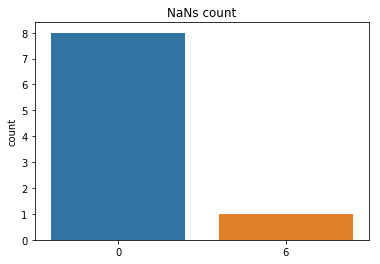

In [12]:
print(data.isna().sum())
sns.countplot(data.isna().sum()).set_title("NaNs count");

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64


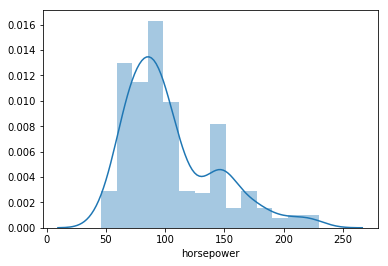

In [13]:
print(data["horsepower"].describe())
sns.distplot(data["horsepower"].dropna());

In [14]:
data["horsepower"][data["horsepower"].isna()] = data["horsepower"].median()

In [21]:
def dist_corr(X, Y, pval=True, nruns=2000):
    """ Distance correlation with p-value from bootstrapping
    """
    dc = dcor.distance_correlation(X, Y)
    pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]
    if pval:
        return (dc, pv)
    else:
        return dc
    
def corrfunc(x, y, **kws):
    d, p = dist_corr(x,y) 
    if p > 0.1 and d<=0.5:
        pclr = 'Darkgray'
    else:
        pclr= 'Darkblue'
    ax = plt.gca()
    ax.annotate("DC = {:.2f}".format(d), xy=(.1, 0.99), xycoords=ax.transAxes, color = pclr, fontsize = 14)
    
def mic(X,Y,pval=True,nruns=100):
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(X,Y)
    mic = mine.mic()
    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Y)
            np.random.shuffle(Y_r)
            mine.compute_score(X,Y_r)
            cur_mine = mine.mic()
            if cur_mine >= mic:
                greater += 1
        return (mic, greater / float(nruns))
    else:
        return mic    
    
    
def mic_corrfunc(x,y,**kw):
    d, p = mic(x,y) 
    if p > 0.1 and d<=0.5:
        pclr = 'Darkgray'
    else:
        pclr= 'Darkblue'
    ax = plt.gca()
    ax.annotate("MIC = {:.2f}".format(d), xy=(.1, 0.99), xycoords=ax.transAxes, color = pclr, fontsize = 14)
    

### Dist corr pairGrid

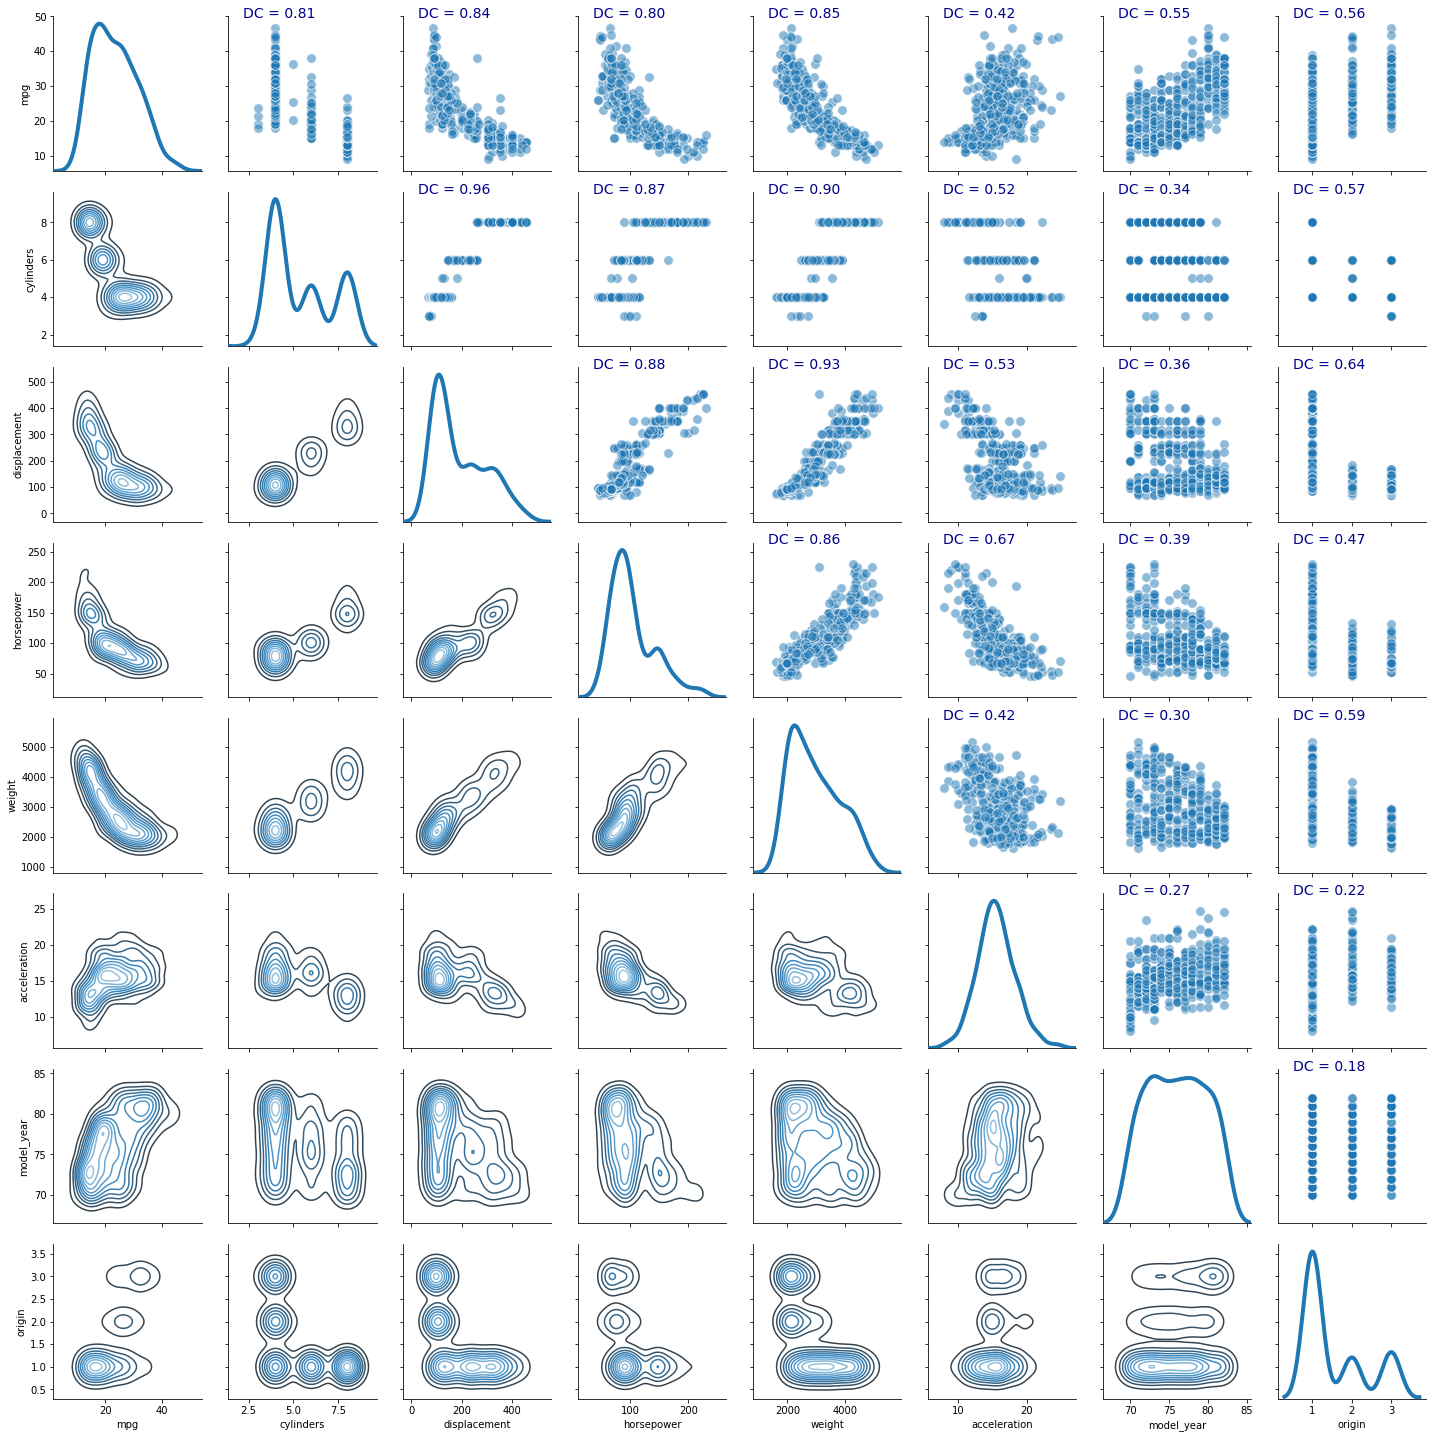

In [16]:
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes
g.map_upper(plt.scatter, linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
plt.show();

### MIC pairgrid


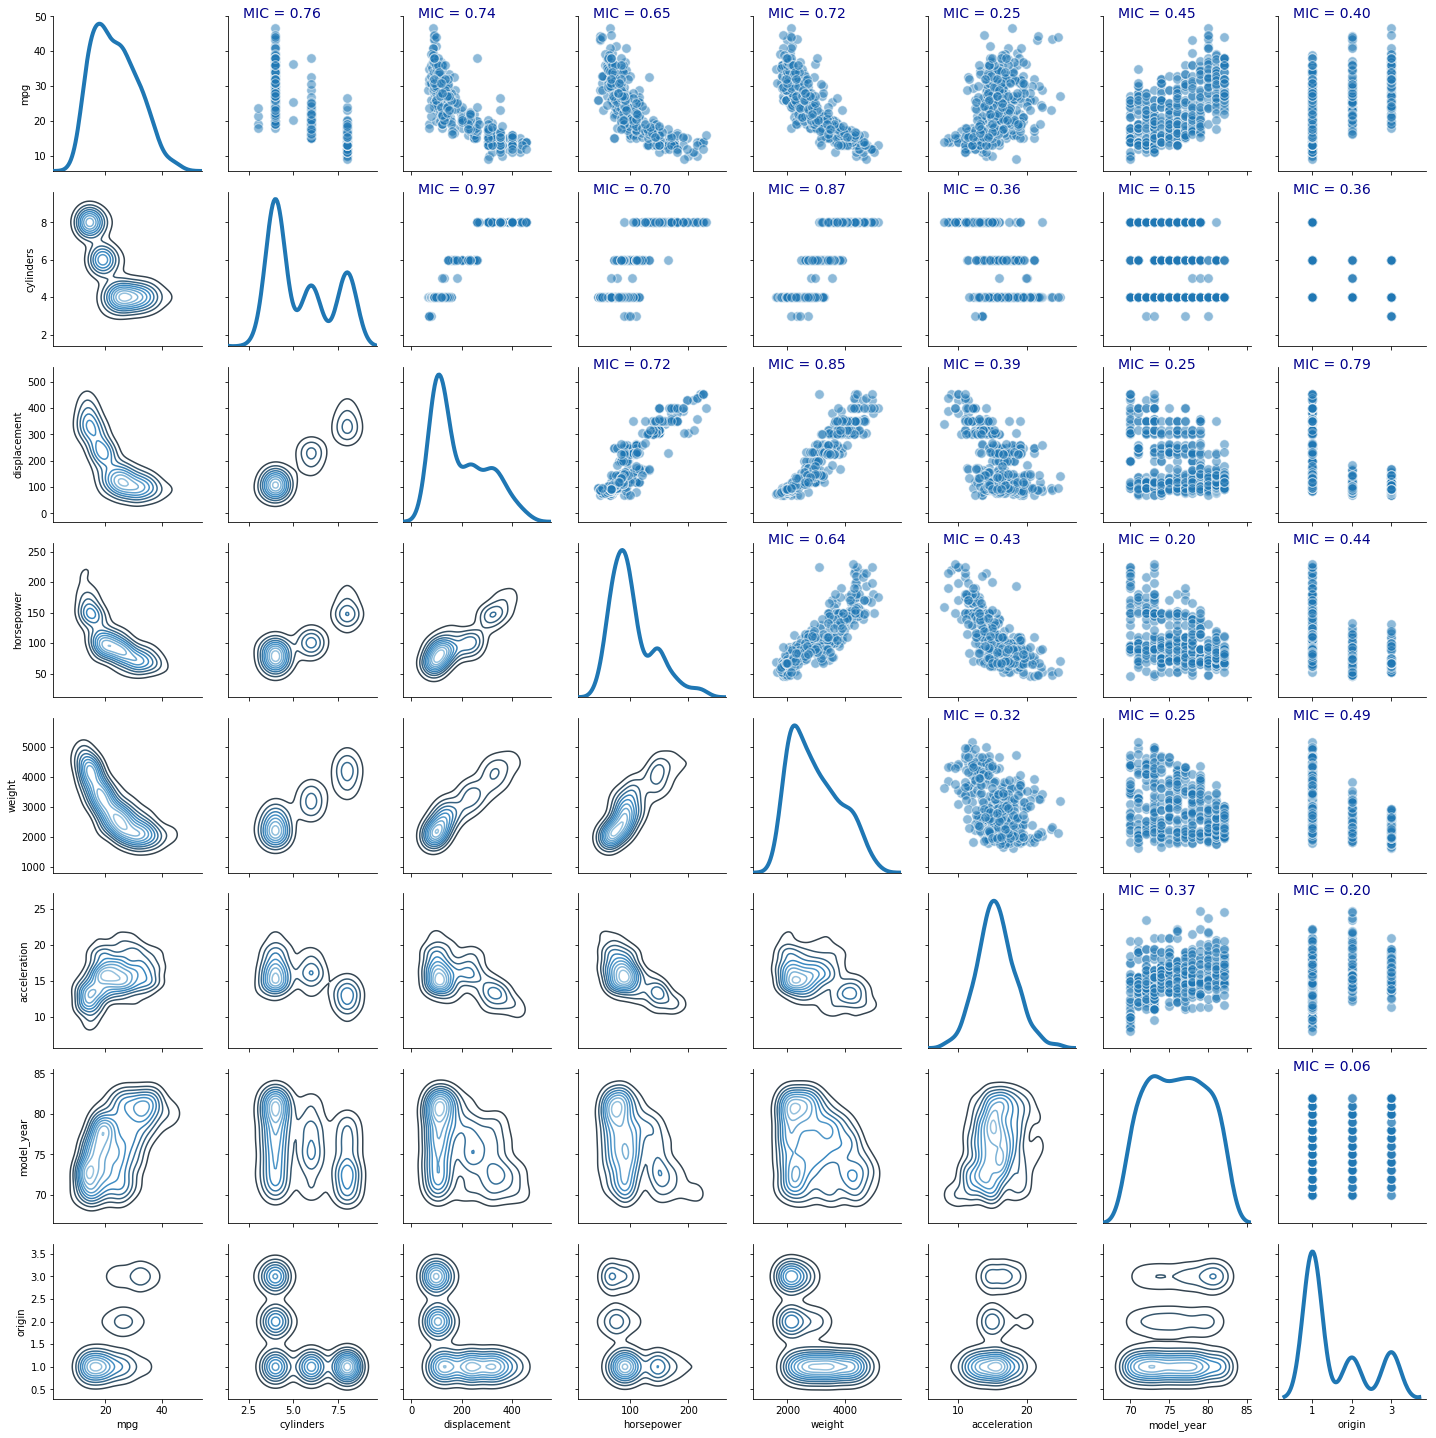

In [22]:
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes
g.map_upper(plt.scatter, linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(mic_corrfunc)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
plt.show();

In [25]:
data.drop(columns=["name"],inplace=True)

In [28]:
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
corr_mat = data.apply(lambda col1: data.apply(lambda col2: distcorr(col1, col2)))
# check output
pd.options.display.float_format = '{:,.2f}'.format
corr_mat

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.00,0.81,0.84,0.80,0.85,0.42,0.55,0.56
cylinders,0.81,1.00,0.96,0.87,0.90,0.52,0.34,0.57
displacement,0.84,0.96,1.00,0.88,0.93,0.53,0.36,0.64
horsepower,0.80,0.87,0.88,1.00,0.86,0.67,0.39,0.47
weight,0.85,0.90,0.93,0.86,1.00,0.42,0.30,0.59
acceleration,0.42,0.52,0.53,0.67,0.42,1.00,0.27,0.22
model_year,0.55,0.34,0.36,0.39,0.30,0.27,1.00,0.18
origin,0.56,0.57,0.64,0.47,0.59,0.22,0.18,1.00


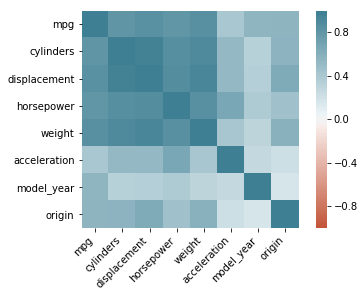

In [29]:
ax = sns.heatmap(
    corr_mat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);